In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2


from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, cdist
from ipywidgets import interact, interact_manual
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.externals import joblib
from logo_classifier import test_sample, k_best, model
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


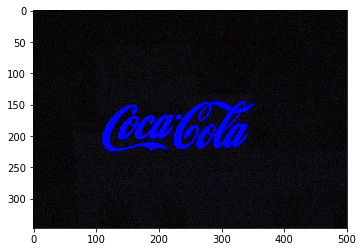

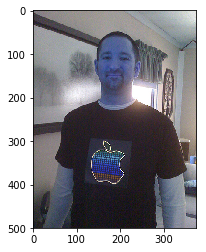

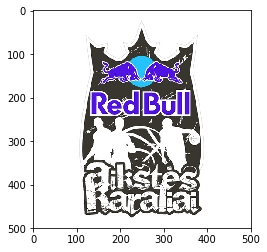

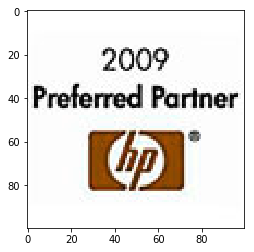

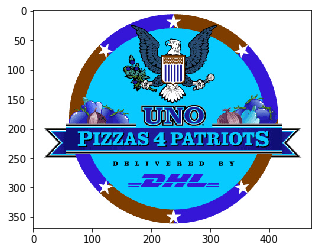

In [12]:
#test_imgs = [np.array(cv2.imread(i), dtype=np.float32)
#             for i in test_files]
for im in k_best(5, 'test/nob.png')[1].squeeze():
    i = cv2.imread(im)
    plt.imshow(i)
    plt.figure()

## Image comparison

In [ ]:
#model = 

In [ ]:
test_dir = 'test/'
test_files = [os.path.join(test_dir, im) for im in os.listdir(test_dir)]

@interact_manual(image_path=test_files, reset_features=False)
def get_feature(image_path, reset_features=False):
    global features, model
    try:
        features
    except:
        features = {}
    if reset_features:
        features = {}
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features[image_path] = model.predict(x).squeeze()
    return features[image_path].shape

In [ ]:
features = pd.DataFrame(features)

In [ ]:
# Compute distances with respect to an image

@interact_manual(img=features.keys())
def distances(img):
    global distances
    distances = np.array([cdist(features[img], i, metric='minkowski') for i in features.values()]).squeeze()
    names = [os.path.basename(i) for i in features.keys()]
    names = [os.path.splitext(i)[0] for i in names]
    print(names)
    plt.bar(list(range(distances.shape[0])),
            distances,
            tick_label=names)
    plt.show()
    return distances

In [ ]:
cdist(features['test/atlas.png'], features['test/nob.png']),
cdist(features['test/nob.png'], features['test/atlas.png'])

## Color Histograms

In [ ]:
@interact_manual(img=test_files, reset_hists=False)
def extract_color_histogram(img, reset_hists=False):
    global hists
    try:
        hists
    except:
        hists = {}
    if reset_hists:
        hists = {}
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    bins = (8, 8, 8)
    im = cv2.imread(img)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    hists[img] = hist.flatten()
    return hist.flatten().shape

In [ ]:
hists = pd.DataFrame(hists)

## K-NN Classifier

In [ ]:
@interact(origin={'histograms': hists, 'vgg16': features},
          k=(2, 15))
def build_knn(origin, k):
    global knn, X
    knn = NearestNeighbors(n_neighbors=k)
    X = pd.DataFrame(origin).T
    knn.fit(X)
    return knn

In [ ]:
# Testing
test = pd.DataFrame(features)
distances, indices = knn.kneighbors(test.T)
for i, f in enumerate(test.keys()):
    print(i, f)

In [ ]:
indices

In [ ]:
lel = pd.DataFrame(features)
lel.keys()

## Scoring

| Vector        | Euclidean weight | Manhattan weight | Weighted sum |
| ------------- | ---------------- | ---------------- | ------------ |
| CNN features  | 0.6              | 0.4              | 0.8 * S_1    |
| histogram     | 0.6              | 0.4              | 0.2 * S_2    |

In [ ]:
# Load dataset
files = pd.read_pickle('dataset.pkl')
enc = LabelEncoder()
enc.fit_transform(files.get_values().ravel())

In [ ]:
cnn = joblib.load('cnn-train-knn.pkl')

In [ ]:
# CNN
features = {}
for t in test_files:
    img = image.load_img(t, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features[t] = model.predict(x).squeeze()
features = pd.DataFrame(features)
distances_cnn, indices_cnn = test_sample(features.T, cnn)

In [ ]:
test = dict(zip(features.keys(), indices_cnn))
@interact(option=features.keys())
def decode(option):
    neighbors = test[option]
    for index in neighbors:
        im = cv2.imread(enc.inverse_transform(index))
        plt.imshow(im)
        plt.figure()

In [ ]:
# Compute CNN score
alpha = 0.8
cnn_scores = (1.0/alpha) * distances_cnn

In [ ]:
hist = joblib.load('hist-train-knn.pkl')

In [ ]:
# Histogram
hists = {}
for im in test_files:
    bins = (8, 8, 8)
    img = cv2.imread(im)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                     [0, 180, 0, 256, 0, 256])
    cv2.normalize(h, h)
    hists[im] = h.flatten()
hists = pd.DataFrame(hists)
distances_h, indices_h = test_sample(hists, hist)

In [ ]:
test = dict(zip(hists.keys(), indices_h))
@interact(option=hists.keys())
def decode(option):
    neighbors = test[option]
    for index in neighbors:
        im = cv2.imread(enc.inverse_transform(index))
        plt.imshow(im)
        plt.figure()

In [ ]:
# Compute Histogram score
beta = 0.2
hist_scores = distances_h * (1.0 / beta)

In [ ]:
# Overall score
conc = np.concatenate((cnn_scores, hist_scores), axis=1)
conc_indices = np.concatenate((indices_cnn, indices_h), axis=1)
test = dict(zip(hists.keys(), conc))
test_indices = dict(zip(hists.keys(), conc_indices))
@interact(k=(1, 20), choice=hists.keys())
def k_best(k, choice):
    global conc, conc_indices
    array = test[choice]
    best_indices = np.argpartition(array, k)
    return [test_indices[choice][i] for i in best_indices[:k]]

In [15]:
help(cv2.imshow)

Help on built-in function imshow:

imshow(...)
    imshow(winname, mat) -> None
    .   @brief Displays an image in the specified window.
    .   
    .   The function imshow displays an image in the specified window. If the window was created with the
    .   cv::WINDOW_AUTOSIZE flag, the image is shown with its original size, however it is still limited by the screen resolution.
    .   Otherwise, the image is scaled to fit the window. The function may scale the image, depending on its depth:
    .   
    .   -   If the image is 8-bit unsigned, it is displayed as is.
    .   -   If the image is 16-bit unsigned or 32-bit integer, the pixels are divided by 256. That is, the
    .   value range [0,255\*256] is mapped to [0,255].
    .   -   If the image is 32-bit or 64-bit floating-point, the pixel values are multiplied by 255. That is, the
    .   value range [0,1] is mapped to [0,255].
    .   
    .   If window was created with OpenGL support, cv::imshow also support ogl::Buffer , og

In [2]:
import pandas as pd

pd.read_csv('../weather_data_train.csv', header=None)

,0,1
0,How hot is it today?,temperature
1,Is it hot outside?,temperature
2,Will it be uncomfortably hot?,temperature
3,Will it be sweltering?,temperature
4,How cold is it today?,temperature
5,Is it cold outside?,temperature
6,Will it be uncomfortably cold?,temperature
7,Will it be frigid?,temperature
8,What is the expected high for today?,temperature
9,What is the expected temperature?,temperature
